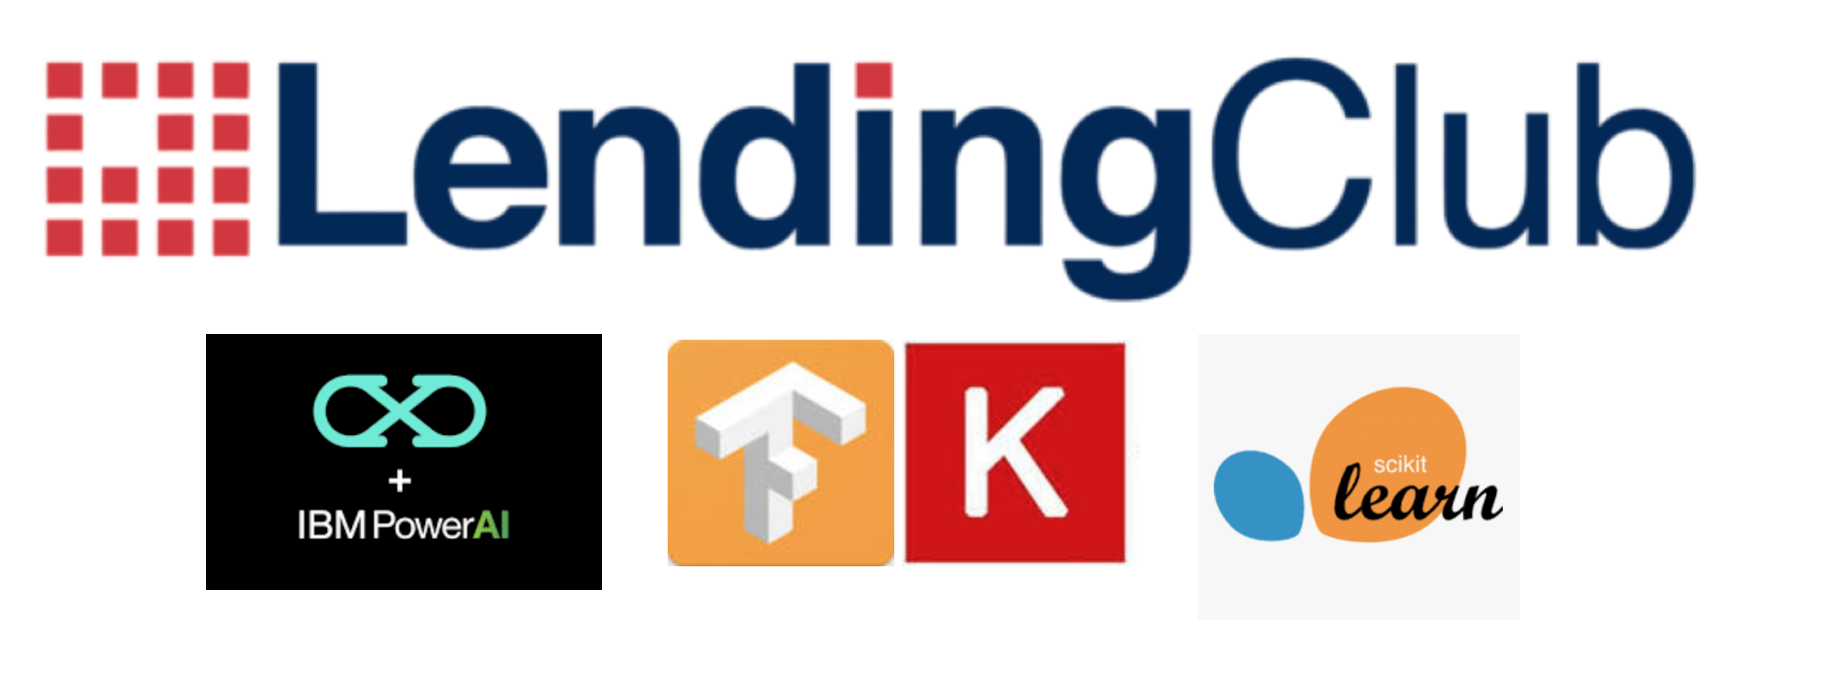

[Lending Club (LC)](https://www.lendingclub.com/) is the world’s largest online marketplace connecting borrowers and investors. It is transforming the banking system to make credit more affordable and investing more rewarding. Lending Club operates at a lower cost than traditional bank lending programs and pass the savings on to borrowers in the form of lower rates and to investors in the form of solid risk-adjusted returns.

The DATA
The original data set is downloaded from [LC](https://www.lendingclub.com/info/download-data.action) covering complete loan data for all loans issued through the 2007-2018, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. Additional features include credit history, number of finance inquiries, address including zip codes, and state, and collections among others. It is quite rich and is an excellent example of credit risk data. Interestingly, Goldman Sachs’ new peer-to-peer lending platform called Marcus was built almost entirely using the Lending Club data.

The original dataset came from LendingClub and was refined and preparred for model training in a notebook created by Bob Chesebrough and Dustin VanStee. They are data scientist at the IBM Cognitive Systems Solution Center. See Dustin's github project at https://github.com/dustinvanstee/lendingclub-examples/tree/master/techu.

### Load the Data

In [1]:
import numpy as np
import pandas as pd
print(pd.__version__)
import sys
import warnings
warnings.filterwarnings('ignore')

loan_df = pd.read_csv('/project_data/data_asset/LoanStats_securev1_2016Q1.csv', index_col=None, header=1)

loan_df.describe()

0.20.1


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,133887.000000,133887.000000,133887.000000,133887.000000,1.338870e+05,133870.000000,133887.000000,133887.000000,133887.000000,...,774.0,774.000000,774.0,774.000000,635.000000,774.000000,774.000000,1087.000000,1087.000000,1087.000000
mean,NaN,15589.394041,15589.394041,15581.984023,460.863923,8.046397e+04,19.547033,0.343476,695.750633,699.750827,...,3.0,155.200801,3.0,11.948320,451.392425,12015.551279,174.638320,6451.076624,50.355115,14.431463
std,NaN,8858.198349,8858.198349,8856.454888,261.612887,7.808478e+04,9.966931,0.908581,31.621999,31.622918,...,0.0,115.423467,0.0,10.164999,340.693887,6644.414291,184.435131,4220.793077,7.788569,7.940075
min,NaN,1000.000000,1000.000000,775.000000,30.120000,0.000000e+00,-1.000000,0.000000,660.000000,664.000000,...,3.0,7.640000,3.0,0.000000,22.920000,627.960000,0.010000,395.320000,20.000000,0.000000
25%,NaN,8400.000000,8400.000000,8400.000000,265.680000,4.950000e+04,12.640000,0.000000,670.000000,674.000000,...,3.0,67.732500,3.0,0.000000,187.935000,6711.922500,27.702500,3195.270000,45.000000,10.000000
50%,NaN,14400.000000,14400.000000,14400.000000,398.520000,6.800000e+04,18.760000,0.000000,690.000000,694.000000,...,3.0,123.095000,3.0,12.000000,357.510000,10887.405000,118.470000,5518.400000,50.000000,16.000000
75%,NaN,21000.000000,21000.000000,21000.000000,613.910000,9.500800e+04,25.770000,0.000000,710.000000,714.000000,...,3.0,213.737500,3.0,21.000000,606.120000,16366.035000,263.500000,8591.785000,55.000000,18.000000
max,NaN,40000.000000,40000.000000,40000.000000,1536.950000,9.550000e+06,999.000000,22.000000,845.000000,850.000000,...,3.0,629.990000,3.0,32.000000,1889.970000,32348.480000,1407.860000,22671.000000,90.000000,65.000000


In [2]:
# lc_utils.py

# Code functions that are needed to run this lab
import sys
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime
import math

import pandas as pd
#from pandas import scatter_matrix
from pandas.plotting import scatter_matrix


#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import glob

# custom library for some helper functions 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict
import seaborn as sns
from itertools import compress
import itertools
import operator

# utility print function
def nprint(mystring) :
    print("**{}** : {}".format(sys._getframe(1).f_code.co_name,mystring))

def load_sample_data(location='/data/work/osa/2018-04-lendingclub/lending-club-loan-data/lendingclub.com/') :
    #For lab force LoanStats_securev1_2018Q1.csv
    loanstats_csv_files = None
    if(myenv.CLASS_ENVIRONMENT == 'nimbix') :
        location='/dl-labs/mldl-101/lab5-powerai-lc/'
        nprint("Setting data location to {}".format(location))
        loanstats_csv_files = glob.glob(location + 'LoanStats_securev1_2016Q1*csv.gz')  # 'LoanStats_secure*csv'
    elif(myenv.CLASS_ENVIRONMENT == 'acc') :
        location='./'
        nprint("Setting data location to {}".format(location))
        loanstats_csv_files = glob.glob(location + 'LoanStats_securev1_2016Q1*csv.gz')  # 'LoanStats_secure*csv'
    else :
        location='./'
        loanstats_csv_files = glob.glob(location + 'LoanStats_securev1_2016Q1*csv')  # 'LoanStats_secure*csv'
    loan_list = []
    nprint("CSV files = {}".format(loanstats_csv_files))
    for i in range(1) : #len(loanstats_csv_files)
        nprint("Loading {}".format(loanstats_csv_files[i]))
        loan_list.append( pd.read_csv(loanstats_csv_files[i], index_col=None, header=1))
        loan_df = pd.concat(loan_list,axis=0)
    return loan_df

def quick_overview_1d(loan_df) :
    nprint("There are " + str(len(loan_df)) + " observations in the dataset.")
    nprint("There are " + str(len(loan_df.columns)) + " variables in the dataset.")

    nprint("\nCategorical vs Numerical")
    dt = pd.DataFrame(loan_df.dtypes)
    dt.columns = ['type']
    nprint("use df.dtypes ...")
    print(dt['type'].value_counts())



    nprint("\n******************Dataset Descriptive Statistics (numerical columns only) *****************************\n")
    print(" running df.describe() ....")
    return loan_df.describe()

def quick_overview_2d(loan_df, cols) :
    nprint("There are " + str(len(loan_df)) + " observations in the dataset.")
    nprint("There are " + str(len(loan_df.columns)) + " variables in the dataset.")

    df = loan_df[cols]
    corr_df = df.corr()
    # plot the heatmap
    sns.set_style(style = 'white')
    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    sns.heatmap(corr_df, cmap=cmap,
        xticklabels=corr_df.columns,
        yticklabels=corr_df.columns,vmin=-1.0,vmax=1.0)


def create_loan_default(df) :
    # use a lamba function to encode multiple loan_status entries into a single 1/0 default variable
    nprint("Unique values in loan_status")
    print(df['loan_status'].value_counts())

    df['default'] = df['loan_status'].isin([
        'Default',
        'Charged Off',
        'Late (31-120 days)',
        'Late (16-30 days)',
        'Does not meet the credit policy. Status:Charged Off'
    ]).map(lambda x: int(x))
    
    # Now that we converted loan_status, drop it for later predictions using just default column
    nprint("Dropping other values that are highly correlated with loan_status")
    nprint("Dropping loan_status,total_rec_prncp,total_pymnt,total_pymnt_inv")


    df = df.drop(['loan_status', 'total_rec_prncp','total_pymnt','total_pymnt_inv'], axis=1)
    nprint("Unique values in default")
    print(df['default'].value_counts())

    return df

def clean_lendingclub_data(df) :
    nprint(" Running a couple routines to clean the data ...")
    df = drop_sparse_numeric_columns(df, threshold=0.025)
    nprint("Current DF shape = {}".format(df.shape))
    df = drop_columns(df)
    nprint("Current DF shape = {}".format(df.shape))
    df = impute_columns(df)
    nprint("Current DF shape = {}".format(df.shape))
    df = handle_employee_length(df)
    nprint("Current DF shape = {}".format(df.shape))
    df = handle_revol_util(df)
    nprint("Current DF shape = {}".format(df.shape))
    df = drop_rows(df)
    nprint("Current DF shape = {}".format(df.shape))
    return df


# This function is only useful for numeric columns .  Essentially, run a describe, and
# remove any amount of columns that have values <= a sparsity threshold
def drop_sparse_numeric_columns(df, threshold=0.01) :
    nprint("Dropping columns with less than {} pct cells populated".format(threshold))
    class useless_columns(BaseEstimator, TransformerMixin):
        def __init__(self) :
            a=0
        def fit(self,X,y=None) :
            return self # do nothing, no implementation
        def transform(self,X,y=None) :
            assert isinstance(X, pd.DataFrame)
            remove_cols = []
            # Use describe to filter out columns with a lot junk ...
            X_desc = X.describe()
            count_idx = 0
            max_rows = max([X_desc[i][count_idx] for i in X_desc.columns])

            for c in X_desc.columns :
                #count is the 0th index
                col_sparsity_val = float(X_desc[c][count_idx]) / float(max_rows)

                if( col_sparsity_val <= threshold) : 
                    nprint("Dropping {} since its {} pct populated".format(c,col_sparsity_val))
                    remove_cols.append(c)
                    #print(remove_cols)
            X = X.drop(remove_cols, axis=1)
            # X = X.DataFrame.drop(columns=remove_cols, axis=1)
            return X


    uc = useless_columns()
    df = uc.transform(df)
    return df


def drop_columns(df) :
    nprint("Dropping columns based on lack of examples ..")

    nprint("Initial number of columns = {}".format(len(df.columns)))

    # Note that in the output of describe, I have some columns with less than my 39999 rows.. this is due to NaN 
    # loan_short_df = loan_short_df.fillna(0)
    # loan_short_df[loan_short_df.isnull().any(axis=1)].shape
    # Print out rows with NaNs --> loan_short_df[loan_short_df.isnull().any(axis=1)].head()
    
    drop_list = ['url','debt_settlement_flag_date','next_pymnt_d']
    drop_dates = ['payment_plan_start_date','last_pymnt_d','last_credit_pull_d']
    
    drop_nlp_cand = ['title','emp_title','desc']
    # create hardship indicator -> drop hardship ....
    drop_hardship =['hardship_end_date','hardship_flag','hardship_loan_status','hardship_reason','hardship_start_date','hardship_status','hardship_type']
    
    #create settlement indictor -> 
    drop_settles = [ 'settlement_date','settlement_status']
    
    # Handle NaN for months since ..... these numbers should be high ..
    #<- transform logic
    drop_msince = ['mths_since_last_delinq','mths_since_last_major_derog','mths_since_last_record','mths_since_recent_bc','mths_since_recent_bc_dlq','mths_since_recent_inq','mths_since_recent_revol_delinq','mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl']
    
    # These could be imputed, but drop for now ...
    drop_total = ['total_rev_hi_lim','tot_coll_amt','tot_cur_bal','tot_hi_cred_lim','total_il_high_credit_limit']
    
    # there is information here .. imputer later (maybe based on GRADE ?)
    drop_nums = ['num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m']
    drop_joint = ['verification_status_joint']

#    df = df.drop(columns=drop_list,axis=1).\
#            drop(columns=drop_dates,axis=1).\
#            drop(columns=drop_nlp_cand,axis=1).\
#            drop(columns=drop_hardship,axis=1).\
#            drop(columns=drop_settles,axis=1).\
#            drop(columns=drop_msince,axis=1).\
#            drop(columns=drop_total,axis=1).\
#            drop(columns=drop_nums,axis=1).\
#            drop(columns=drop_joint,axis=1)

    df = df.drop(drop_list,axis=1).\
            drop(drop_dates,axis=1).\
            drop(drop_nlp_cand,axis=1).\
            drop(drop_hardship,axis=1).\
            drop(drop_settles,axis=1).\
            drop(drop_msince,axis=1).\
            drop(drop_total,axis=1).\
            drop(drop_nums,axis=1).\
            drop(drop_joint,axis=1)
    
    nprint("Final number of columns = {}".format(len(df.columns)))

    return df

def impute_columns(df) :
    nprint("Imputing Values for some columns that are mostly populated")

    # Fill 0 candidates for now - Add justification later ...
    df['percent_bc_gt_75'].fillna(0,inplace=True)
    df['bc_open_to_buy'].fillna(0,inplace=True)
    df['bc_util'].fillna(0,inplace=True)
    df['pct_tl_nvr_dlq'].fillna(0,inplace=True)  # Percent trades never delinquent
    df['avg_cur_bal'].fillna(3000,inplace=True)  # set to around lower 25% percentile
    df['acc_open_past_24mths'].fillna(4,inplace=True)  # set to around lower 25% percentile
    df['mort_acc'].fillna(1,inplace=True)  # set to around lower 25% percentile
    
    df['total_bal_ex_mort'].fillna(18000,inplace=True)# set to around lower 50% percentile
    df['total_bc_limit'].fillna(7800,inplace=True)# set to around lower 50% percentile
    return df


# create emp_length indictor variable 
# emp_length <- impute that with simple formula based on diff mdl ...
def handle_employee_length(df) :
    nprint("Binning employee length into 3 categories")
    def emp_func(row):
        if(isinstance(row['emp_length'], str)) :
            if row['emp_length'] == '1 years' or row['emp_length'] == '2 years' or row['emp_length'] == '3 years':
                return '0_3yrs'
            elif row['emp_length'] == '4 years' or row['emp_length'] == '5 years' or row['emp_length'] == '6 years':
                return '4_6yrs' 
            else:
                return 'gt_6yrs'
        else :
            return '0_3yrs'
    
    df['emp_bin'] = df.apply(emp_func, axis=1)
    #df.drop(columns='emp_length',axis=1,inplace=True)
    df.drop('emp_length',axis=1,inplace=True)
    return df

def handle_revol_util(df) :
    nprint("Cleaning missing values for revol_util")

    def revol_util_func(row) :
        if(isinstance(row['revol_util'], int)) :
            return row['revol_util']
        else :
            return float(row['revol_bal']/(row['revol_bal']+row['loan_amnt']))
    
    df['revol_util_1'] = df.apply(revol_util_func, axis=1)
    #df.drop(columns='revol_util',axis=1,inplace=True)
    df.drop('revol_util',axis=1,inplace=True)
    return df


def columns_with_nans(df) :
    # nprint(df.isna().sum())
    nprint(df.isnull().sum())


# dropping rows with lots of NaNs
def drop_rows(df) :
    r0 = len(df)
    df = df.dropna()
    r1 = len(df)

    nprint("Removed {} rows due to high number of NaN".format(r0-r1))
    return df


def create_time_features(df) :
    nprint("Creating new column called time_history : Calculated feature showing how long applicant has been a borrower..")
    class clean_time_columns(BaseEstimator, TransformerMixin):
        def __init__(self) :
            a=0
        def fit(self,X,y=None) :
            return self # do nothing, no implementation
        def transform(self,X,y=None) :
            assert isinstance(X, pd.DataFrame)
            X = X.copy()
            # turn MM-YYYY into YYYY-MM-DD
            X['issue_d'] = X['issue_d'].map(lambda x: datetime.strptime(x, "%b-%Y"))
            X['earliest_cr_line'] = X['earliest_cr_line'].map(lambda x: datetime.strptime(x, '%b-%Y'))
            X['time_history'] = X['issue_d'] - X['earliest_cr_line']
            X['time_history'] = X['time_history'].astype('timedelta64[D]').astype(int)
    
            return X

    cln = clean_time_columns()
    df = cln.transform(df)
    return df


# One-hot encoder for all categorical varaibles
# If cardinality < 50, will build, otherwise drop for now ....
def one_hot_encode_keep_cols(df) :
    cardinatity_limit = 50 
    # This first section identifies the columns to keep and drop based on cardinality
    cat_df = df.select_dtypes(include=['object'])

    cat_df = cat_df.apply(pd.Series.nunique).reset_index()
    cat_df = cat_df.rename(columns={'index' : 'column_name', 0:'count'})
    keep_cols = cat_df[(cat_df['count'] < cardinatity_limit) & (cat_df['count'] >1)]
    drop_cols = cat_df[(cat_df['count'] >= cardinatity_limit) | (cat_df['count'] == 1)]

    cat_keep_list = list(keep_cols['column_name'].values)
    cat_drop_list = list(drop_cols['column_name'].values)
    nprint("Dropping these columns since they are greater than cardinality limit of {}".format(cardinatity_limit))
    nprint(cat_drop_list)
    nprint("Keeping these cols")
    nprint(cat_keep_list)
    # This second  section performs the one hot encoding on the columns identified in cat_keep_list

    tmp_dummies_df_list = [df]
    for cat in cat_keep_list :
        tmp_dummies_df_list.append(pd.get_dummies(df[cat]))
        
        
    df2 = pd.concat(tmp_dummies_df_list, axis=1)
    #df2 = df2.drop(columns=cat_keep_list)
    #df2 = df2.drop(columns=cat_drop_list)
    df2 = df2.drop(cat_keep_list,axis=1)
    df2 = df2.drop(cat_drop_list,axis=1)
    df2['id'] = df['id']
    #.drop(cat_keep_list)
    return df2

def plot_histograms(df) :
    for c in df.columns :
        if(df[c].dtype == 'float64' or df[c].dtype == 'int64') :
            plt.figure(c)
            df[c].hist(bins=50, figsize=(10,2)).set_xlabel(c)
        else :
            print("skipping column {} of type  {}".format(c,df[c].dtype))

def bob_heatmap_lc(df,sortColumn, add_corr=False):
    df = df.drop(['id','index'], axis=1)
    df = df.sample(n=1000)
    # scale it all on a 0-1 range ....
    df = (df - df.min(0)) / (df.max(0) -df.min(0))

    plt.figure(figsize=(30, 20))
    
    CMAP = "gist_heat"
    #CMAP = "gist_ncar"
    
    if(sortColumn not in df.columns): # check if a sort column was passed in
        ax = sns.heatmap(df, yticklabels = 1000, cmap=CMAP, center = 1)
    else:
        ax = sns.heatmap(df.sort_values(by=[sortColumn]), yticklabels = 1000, cmap=CMAP, center = 1)

    if(add_corr) :
        corr_vs_1var(df, sortColumn) 

def corr_vs_1var(df, var_to_corr) :
    corr_dict = {}

    nprint("removing object types")
    df = df.select_dtypes(exclude=['object'])

    for c in df.columns :
        if(c != var_to_corr and c != 'index') :
            #nprint("{} {}".format(c,type(c)))
            corr_dict[c] = df[var_to_corr].corr(df[c])
    
    sorted_list = sorted(corr_dict.items(), key=operator.itemgetter(1))
    print("{:60s} {:20s}".format("Highest Positive", "Highest Negative"))
    print("{:60s} {:20s}".format("Correlation", "Correlation"))
    print("{:60s} {:20s}".format("==============", "=============="))
    for x in range(20) :
        print("{:60s} {:20s}".format(str(sorted_list[x]), str(sorted_list[-1-x])))


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig('confusion_mat.png', bbox_inches='tight', format='png', dpi=300, pad_inches=0,transparent=True)
    plt.show()
    return


################################### Machine Learning Funcs ############################################

class lendingclub_ml:


    def __init__(self,df):
        self.df = df
        self.train_df = None
        self.test_df = None

        self.X_train_scaled = None 
        self.Y_train = None 
        self.X_test_scaled = None 
        self.Y_test = None 
        self.pca_model = None
        self.ae_model = None

    
    def create_train_test(self, test_size=0.4) :
        # Train / Test split
        nprint("Dropping 2 timestamp columns issue_d and earliest_cr_line")
        self.df = self.df.drop(['issue_d','earliest_cr_line'],1)
    
        self.train_df, self.test_df = train_test_split(self.df, test_size=test_size, random_state=52)
        
        X_train = self.train_df.drop(['default','id'],1)
        self.Y_train = self.train_df['default']
        
        X_test = self.test_df.drop(['default','id'],1)
        self.Y_test = self.test_df['default']
        # Normalize ??
        
        # Scale the Data Here in a common way
        scaler = StandardScaler(with_mean=True,with_std=True)
        X_train_scaled = scaler.fit_transform(X_train)   # same as (df-df.mean())/df.std(ddof=0)
        X_test_scaled = scaler.transform(X_test)   # 
        
        self.X_train_scaled = pd.DataFrame(data=X_train_scaled,columns=X_train.columns)
        self.X_test_scaled  = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)
    
        nprint("Training set size: " + str(self.train_df.shape))
        nprint("Testing set size: " + str(self.test_df.shape))
        nprint("Train set loan_default:loan_paid ratio : " + str(self.train_df[self.train_df.default == 1].shape[0]) +'/' + str(self.train_df[self.train_df.default != 1].shape[0]))
        nprint("Test  set loan_default:loan_paid ratio : " + str(self.test_df[self.test_df.default == 1].shape[0])+'/' + str(self.test_df[self.test_df.default != 1].shape[0]))
    
    
    def build_pca_model(self,n_components=20) :
        # display sorted eigenvalues
    
        # start w n_components principal components and see how much variance that gives me
        # create instance of PCA (constructor)
        pca = PCA(n_components=n_components)
        # pca = PCA(copy=True, iterated_power='auto', n_components=n_components, random_state=None, svd_solver='auto', tol=0.0, whiten=False) 
        pca.fit(self.X_train_scaled)
        nprint("Explained Variance : {}".format(pca.explained_variance_ratio_))
        self.pca_model = pca
        # Plot the values on a scree plot
        self.pca_scree(n_components)



    
    def pca_scree(self, n_components=6) :
        
        # bin is my x axis variable
        bin = []
        for i in range (int(n_components)):
            bin.append(i+1)
        # plot the cummulative variance against the index of PCA
        cum_var = np.cumsum(self.pca_model.explained_variance_ratio_)
        plt.plot(bin, cum_var)
        # plot the 95% threshold, so we can read off count of principal components that matter
        plt.plot(bin, [.95]*n_components, '--')
        plt.plot(bin, [.75]*n_components, '--')
        plt.plot(bin, [.50]*n_components, '--')
        #turn on grid to make graph reading easier
        plt.grid(True)
        #plt.rcParams.update({'font.size': 24})
        plt.suptitle('PC Variance Explained')
        plt.xlabel('Number of PC Components', fontsize=18)
        plt.ylabel('Fraction of Variance \nExplained', fontsize=16)
        # control number of tick marks, 
        plt.xticks([i for i in range(0,n_components)])
        plt.show()
    
    def build_ae_model(self, ae_layers=[25,5,25], regularization=0.001, folds=2, epochs=10, batch_size=32, k_tries=1) :
    #TODO : add experiment for batch size
    
        r = regularization
        kf = KFold(n_splits=folds)
    
        nprint("Dataframe shape = {}".format(self.X_train_scaled.shape))
        for idx, (train_index, cv_index) in enumerate(kf.split(self.X_train_scaled)):
            nprint("idx={}, xlen={} trainlen={} cvlen={}".format(idx, len(self.X_train_scaled), len(train_index), len(cv_index)))
        
        # Get number of columns in training data
        num_cols = len(self.X_train_scaled.columns) 
        
        # Build Autoencoder based on specification
        nprint("Building Autoencoder using this definition : {} {} {} ".format(num_cols, str(ae_layers),num_cols))
        input_layer = Input(shape=(num_cols, ), name="input_layer")
        layer = []
        layer.append(input_layer)
    
        for l in range(len(ae_layers)) :
            layer.append (Dense(ae_layers[l], activation='relu', kernel_regularizer=regularizers.l2(r), name="dense_"+str(l))(layer[l]) )
        
        # see 'Stacked Auto-Encoders' in paper
        decoded = Dense(num_cols, activation= 'linear', kernel_regularizer=regularizers.l2(r), name="final_layer")(layer[-1]) 
        
        
        # construct and compile AE model
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer='sgd', loss='mean_squared_error')
        
        # train autoencoder - Using Kfolds!
        recon_kfold_loss = 0
        for my_try in range(k_tries) :
            for kf_iter, (train_index, cv_index) in enumerate(kf.split(self.X_train_scaled)):
        
                nprint("Inner Loop encoding_dim : {}, regular={}, kfold_iter={}".format(ae_layers,r,kf_iter))
                X_train, X_CV = self.X_train_scaled.iloc[train_index,:], self.X_train_scaled.iloc[cv_index,:]
                
                nprint("X_train shape={} X_CV shape={}".format(X_train.shape,X_CV.shape))
                
                fit_err = autoencoder.fit(X_train, X_train, shuffle=False, epochs=epochs, batch_size = batch_size,verbose=True, validation_data=(X_CV,X_CV))
                loss = fit_err.history['loss'][-1]
            
                # Sum Loss over all folds
                # L1 implemenation
                #recon_kfold_err =  np.linalg.norm(autoencoder.predict(X_CV)-X_CV)
                #recon_error = recon_error + recon_kfold_err
                # L2 implemenation (mse)
                recon_kfold_loss +=  loss
                #recon_error = recon_error + recon_kfold_err
                nprint("Recon err = {} : Current Iter err = {}".format(recon_kfold_loss,loss) )
        
    
        print(autoencoder.summary())
        # Average error over kfolds ...
        final_loss = recon_kfold_loss / folds
        nprint("Final loss {} [work to minimize this with the best settings ..]".format(final_loss) )
    
        self.ae_model = autoencoder
#
    def visualize_dimred_results(self, mode='pca') :
        if(mode == 'pca') :
            cols_ = ['PC0','PC1','PC2','PC3','PC4','PC5']
        else :
            cols_ = ['AE0','AE1','AE2','AE3','AE4','AE5']

        default_colors = self.test_df['default'].apply(lambda x : 'red' if x == 1 else 'green')

        scatter_matrix(self.test_df[cols_], alpha=0.1, figsize=[10,10], grid=True, c=default_colors, diagonal='kde')
        #scatter_matrix(encode_X[cols_], alpha=0.4, figsize=[10,10], grid=True)

        #marker='o',c=pcomps.Churn.apply(lambda x:churn_colors[x]
        plt.show()


    def drop_pca_ae_cols(self, df) :
        drop_cols = [x for x in df.columns if 'PC' in x]
        if(len(drop_cols) > 0) :
            df = df.drop(drop_cols,axis=1)
        drop_cols = [x for x in df.columns if 'AE' in x]
        if(len(drop_cols) > 0) :
            df = df.drop(drop_cols,inplace=True,axis=1)
        return df

    def update_train_test_df(self) :
        self.train_df = self.update_df(self.train_df, mode='train')
        self.test_df  = self.update_df(self.test_df, mode='test')

    def update_df(self, df, mode='train') :
        nprint("Starting update for {} dataframe ".format(mode))

        df = self.drop_pca_ae_cols(df)
        if(mode == 'train') :
            X_scaled = self.X_train_scaled
        else :
            X_scaled = self.X_test_scaled


        # Create Test data encoded values
        nprint("Adding PCA columns first")

        pca_encode_X = self.pca_model.transform(X_scaled)  #get the actual principal components as vectors
        pca_encode_X = pd.DataFrame(data=pca_encode_X)
        cols_ = {i:"PC"+str(i) for i in pca_encode_X.columns}
        nprint("Creating new columns : {}".format(cols_))
        pca_encode_X.rename(columns=cols_, inplace=True)

        nprint("Adding AE columns next")
        #outputs = [layer.output for layer in self.ae_model.layers]
        self.ae_model.summary()

        nprint("Grabbing AE Bottleneck layer")
        nl = len(self.ae_model.layers)
        nprint("Num Layers : {}".format(nl))

        nl = int((nl - 2)/2)  # strip off front/back ...find middle.

        btl_layer_str = 'dense_' + str(nl)
        nprint("Bottleneck Layer : {}".format(btl_layer_str))

        ae_bottleneck_model = Model(inputs=self.ae_model.input, outputs=self.ae_model.get_layer(btl_layer_str).output)
        ae_bottleneck_model.summary()

        ae_encode = ae_bottleneck_model.predict(x=X_scaled)
        ae_encode_X = pd.DataFrame(data=ae_encode, index=df.index)
        #print(ae_encode_X.head(5))
        cols_ = {i:"AE"+str(i) for i in ae_encode_X.columns}
        ae_encode_X.rename(columns=cols_, inplace=True)

        nprint(ae_encode_X.columns)

        nprint("Updating {} Dataframe ".format(mode))
        df = pd.concat([df.reset_index(),pca_encode_X,ae_encode_X.reset_index()],axis=1)

        return df


    def build_evaluate_dl_classifier(self, x_cols, regularization=0.001, epochs=3, batch_size = 16) :


        X = self.train_df[x_cols]
        Y = self.Y_train
        X_test = self.test_df[x_cols]
        Y_test = self.Y_test

        #Compare DL vs Logistic ....
        r = regularization
        
        input_layer = Input(shape=(X.shape[1], ), name="input_layer")
        fc0 = Dense(10, activation='relu', kernel_regularizer=regularizers.l2(r), name="FC0")(input_layer)      
        #fc1 = Dense(5, activation= 'sigmoid', kernel_regularizer=regularizers.l2(r), name="FC1")(layer[-1]) 
        output_layer = Dense(1, activation= 'sigmoid', kernel_regularizer=regularizers.l2(r), name="final_layer")(fc0) 
        
                
        # construct and compile AE model
        dl_classifier = Model(input_layer, output_layer)
        dl_classifier.compile(optimizer='sgd', loss='mean_squared_error')
          
        
        dl_classifier.summary()
        fit_err = dl_classifier.fit(X, Y, shuffle=False, epochs=epochs, batch_size = batch_size,verbose=True, validation_data=(X_test,Y_test)) 

        Y_test_predict = np.where(dl_classifier.predict(x=X_test) > 0.5, 1, 0 )

        cnf_matrix =confusion_matrix(Y_test, Y_test_predict)
        class_names =  ['Default','Paid']  
        plot_confusion_matrix(cnf_matrix, class_names)


### Create default feature based on loan status

This is the column we will predict later¶

The loan_status column contains the information of whether or not the loan is in default.

This column has more than just a 'default or paid' status. Since our goal is to build a simple default classifier , we need to make a new column based off the loan_status column.

Here we will look at all the categorical values in loan_status, and create a new column called default based off that one.


In [3]:
# function to create loan status .... 
loan_df = create_loan_default(loan_df)
loan_df.head(3) # scroll to the right, and see the new 'default' column

**create_loan_default** : Unique values in loan_status
Current               79931
Fully Paid            35650
Charged Off           13043
Late (31-120 days)     3157
In Grace Period        1637
Late (16-30 days)       458
Default                  11
Name: loan_status, dtype: int64
**create_loan_default** : Dropping other values that are highly correlated with loan_status
**create_loan_default** : Dropping loan_status,total_rec_prncp,total_pymnt,total_pymnt_inv
**create_loan_default** : Unique values in default
0    117220
1     16669
Name: default, dtype: int64


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,default
0,76003542,NaN,16000.0,16000.0,16000.0,36 months,5.32%,481.84,A,A1,Security specialist,8 years,RENT,105000.0,Not Verified,Mar-2016,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,206xx,MD,15.02,1.0,Nov-2000,720.0,724.0,0.0,9.0,NaN,9.0,0.0,6219.0,27.9%,21.0,w,0.00,0.00,98.34,0.00,0.0,0.0,May-2016,16107.80,NaN,Nov-2016,679.0,675.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,23525.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,22300.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,124.0,184.0,22.0,8.0,0.0,52.0,NaN,8.0,9.0,0.0,2.0,3.0,2.0,5.0,7.0,6.0,14.0,3.0,9.0,0.0,0.0,0.0,2.0,95.2,0.0,0.0,0.0,47543.0,23525.0,19400.0,25243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1,76023477,NaN,17000.0,17000.0,17000.0,36 months,9.75%,546.55,B,B3,Kindergarten Teacher,< 1 year,MORTGAGE,40000.0,Verified,Mar-2016,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,440xx,NC,24.30,0.0,Aug-2006,705.0,709.0,0.0,NaN,NaN,4.0,0.0,14009.0,85.9%,8.0,w,1856.98,1856.98,1487.56,0.00,0.0,0.0,Nov-2017,546.55,Dec-2017,Nov-2017,799.0,795.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,31939.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,16300.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,25.0,115.0,35.0,25.0,0.0,35.0,NaN,6.0,NaN,0.0,3.0,3.0,3.0,5.0,1.0,3.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,44131.0,31939.0,16300.0,27831.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### Data Preparation - Handle Null Values aka NaNs ...

One part of the data science process thats especially time consuming is working with unclean data. This lending club data set is a great example of that. If you look at the dataframe shown above, you will see a number of columns with the indicator NaN . This means 'not a number' and needs to be dealt with prior to any machine learning steps. You have many options here. Some options are listed below...

    Fill with a value -> impute mean/median/min/max/other
    drop rows with NaNs
    drop columns with large number of NaNs
    use data in other columns to derive

All these methods are possible, but its up to the data scientist / domain expert to figure out the best approach. There is definitely some grey area involved in whats the best approach.

First, lets understand which columns have NaNs...

In [4]:
# For every column, count the number of NaNs .... 
# code hint : uses df.isna().sum()

columns_with_nans(loan_df)

**columns_with_nans** : id                                                 0
member_id                                     133889
loan_amnt                                          2
funded_amnt                                        2
funded_amnt_inv                                    2
term                                               2
int_rate                                           2
installment                                        2
grade                                              2
sub_grade                                          2
emp_title                                       8983
emp_length                                         2
home_ownership                                     2
annual_inc                                         2
verification_status                                2
issue_d                                            2
pymnt_plan                                         2
url                                                2
desc                  

As you can see, we have some work to do to clean up the NaN values. Beyond NaN values, we also have to transform columns if they aren't formatted correctly, or maybe we want to transform a column based on custom requirements.

Example : column=employee_length , values=[1,2,3,4,5,6,7,8,9,10+] formatted as a string
          transform into 
          column=employee_length, [0_3yrs,4_6yrs,gt_6yrs] (categorical:strings)

Luckily, we took care to process and clean this data below using a few functions. In practice, this is where data scientists spend a large portion of their time as this requires detailed domain knowledge to clean the data. We have made a fair number of assumptions about how to process the data which we won't go into due to time contraints for the lab.

In [5]:
# The following cleaning of the data makes use of the steps shown below.....

#loan_df1 = drop_sparse_numeric_columns(loan_df)
#loan_df2 = drop_columns(loan_df1)
#loan_df3 = impute_columns(loan_df2)
#loan_df4 = handle_employee_length(loan_df3)
#loan_df5 = handle_revol_util(loan_df4)
#loan_df6 = drop_rows(loan_df5)

loan_df = clean_lendingclub_data(loan_df)

**clean_lendingclub_data** :  Running a couple routines to clean the data ...
**drop_sparse_numeric_columns** : Dropping columns with less than 0.025 pct cells populated
**transform** : Dropping member_id since its 0.0 pct populated
**transform** : Dropping annual_inc_joint since its 0.01987467230317651 pct populated
**transform** : Dropping dti_joint since its 0.019859734556236883 pct populated
**transform** : Dropping revol_bal_joint since its 0.0 pct populated
**transform** : Dropping sec_app_fico_range_low since its 0.0 pct populated
**transform** : Dropping sec_app_fico_range_high since its 0.0 pct populated
**transform** : Dropping sec_app_earliest_cr_line since its 0.0 pct populated
**transform** : Dropping sec_app_inq_last_6mths since its 0.0 pct populated
**transform** : Dropping sec_app_mort_acc since its 0.0 pct populated
**transform** : Dropping sec_app_open_acc since its 0.0 pct populated
**transform** : Dropping sec_app_revol_util since its 0.0 pct populated
**transform**

In [6]:
# Final Sanity check ....
# If we did our job right, there should not be any NaN's left.  
# Use this convenience function to check

# code hint df.isna().sum()

columns_with_nans(loan_df)

**columns_with_nans** : id                            0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
pymnt_plan                    0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_rec_int   

### Data Preparation - Handle Time Objects

Sometimes for columns that contain date information, you may want to break them down into individual columns like month, day, day of week etc. For our use case, we will create a new column called time_history that will indicate how long an applicant has been a borrower. This is an example of feature engineering. Essentially, using business logic to create a new column (feature) that may have predictive value.

In [7]:
loan_df = create_time_features(loan_df)
loan_df.head(3)

**create_time_features** : Creating new column called time_history : Calculated feature showing how long applicant has been a borrower..


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mort_acc,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,disbursement_method,debt_settlement_flag,default,emp_bin,revol_util_1,time_history
0,76003542,16000.0,16000.0,16000.0,36 months,5.32%,481.84,A,A1,RENT,105000.0,Not Verified,2016-03-01,n,debt_consolidation,206xx,MD,15.02,1.0,2000-11-01,720.0,724.0,0.0,9.0,0.0,6219.0,21.0,w,0.00,0.00,98.34,0.00,0.0,0.0,16107.80,679.0,675.0,0.0,1.0,Individual,0.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,0.0,95.2,0.0,0.0,0.0,23525.0,19400.0,Cash,N,0,gt_6yrs,0.279896,5599
1,76023477,17000.0,17000.0,17000.0,36 months,9.75%,546.55,B,B3,MORTGAGE,40000.0,Verified,2016-03-01,n,credit_card,440xx,NC,24.30,0.0,2006-08-01,705.0,709.0,0.0,4.0,0.0,14009.0,8.0,w,1856.98,1856.98,1487.56,0.00,0.0,0.0,546.55,799.0,795.0,0.0,1.0,Individual,0.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,0.0,100.0,100.0,0.0,0.0,31939.0,16300.0,Cash,N,0,gt_6yrs,0.451772,3500
2,75993535,15000.0,15000.0,15000.0,60 months,15.31%,359.30,C,C5,MORTGAGE,70000.0,Source Verified,2016-03-01,n,home_improvement,750xx,TX,9.99,0.0,2002-01-01,690.0,694.0,0.0,6.0,0.0,11630.0,22.0,w,0.00,0.00,2137.08,17.97,0.0,0.0,13106.47,754.0,750.0,0.0,1.0,Individual,0.0,0.0,1.0,1.0,1.0,12.0,15692.0,72.0,1.0,2.0,5840.0,60.0,3.0,0.0,6.0,3.0,4554.0,9808.0,38.7,0.0,0.0,3.0,95.5,33.3,0.0,0.0,27322.0,16000.0,Cash,N,0,gt_6yrs,0.436725,5173


### Convert Categorical Data to One hot encode

If you look above at the data frame, we are almost ready to start building models. However, there is one important step to complete. Notice we have some columns that are still built out of string data

example column=home_ownership values=[RENT, MORTGAGE, OWN]

Machine learning algorithms only process numerical data, so we need to transform these categorical columns into indicator columns

From the example above, the transform would yield 3 new columns

example column=RENT values=[0,1]
        column=MORTGAGE values=[0,1]
        column=OWN values=[0,1]

Conveniently pandas has a nice function called get_dummies that we will use for this purpose


In [8]:
# Transform categorical data into binary indicator columns
# code hint, uses pd.get_dummies

loan_df = one_hot_encode_keep_cols(loan_df)
loan_df.head() # once complete, see how many new columns you have!

**one_hot_encode_keep_cols** : Dropping these columns since they are greater than cardinality limit of 50
**one_hot_encode_keep_cols** : ['id', 'int_rate', 'zip_code', 'addr_state']
**one_hot_encode_keep_cols** : Keeping these cols
**one_hot_encode_keep_cols** : ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'application_type', 'disbursement_method', 'debt_settlement_flag', 'emp_bin']


,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mort_acc,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,default,revol_util_1,time_history,36 months,60 months,A,B,C,D,E,F,G,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,MORTGAGE,OWN,RENT,Not Verified,Source Verified,Verified,n,y,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,f,w,Individual,Joint App,Cash,DirectPay,N,Y,0_3yrs,4_6yrs,gt_6yrs,id
0,16000.0,16000.0,16000.0,481.84,105000.0,2016-03-01,15.02,1.0,2000-11-01,720.0,724.0,0.0,9.0,0.0,6219.0,21.0,0.00,0.00,98.34,0.00,0.0,0.0,16107.80,679.0,675.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,0.0,95.2,0.0,0.0,0.0,23525.0,19400.0,0,0.279896,5599,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,76003542
1,17000.0,17000.0,17000.0,546.55,40000.0,2016-03-01,24.30,0.0,2006-08-01,705.0,709.0,0.0,4.0,0.0,14009.0,8.0,1856.98,1856.98,1487.56,0.00,0.0,0.0,546.55,799.0,795.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,0.0,100.0,100.0,0.0,0.0,31939.0,16300.0,0,0.451772,3500,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,76023477
2,15000.0,15000.0,15000.0,359.30,70000.0,2016-03-01,9.99,0.0,2002-01-01,690.0,694.0,0.0,6.0,0.0,11630.0,22.0,0.00,0.00,2137.08,17.97,0.0,0.0,13106.47,754.0,750.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,12.0,15692.0,72.0,1.0,2.0,5840.0,60.0,3.0,0.0,6.0,3.0,4554.0,9808.0,38.7,0.0,0.0,3.0,95.5,33.3,0.0,0.0,27322.0,16000.0,0,0.436725,5173,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,75993535
3,2425.0,2425.0,2425.0,84.44,25000.0,2016-03-01,38.50,0.0,2007-09-01,705.0,709.0,0.0,7.0,0.0,10604.0,15.0,0.00,0.00,228.18,0.00,0.0,0.0,2062.67,714.0,710.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,24.0,15963.0,65.0,0.0,0.0,7288.0,72.0,0.0,0.0,0.0,1.0,13860.0,12.0,99.8,0.0,0.0,2.0,100.0,100.0,0.0,0.0,26567.0,7300.0,0,0.813877,3104,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,73458582
4,29900.0,29900.0,29900.0,1007.31,68000.0,2016-03-01,17.49,0.0,1991-11-01,675.0,679.0,2.0,14.0,1.0,13984.0,39.0,17215.02,17215.02,4396.13,0.00,0.0,0.0,1007.31,604.0,600.0,1.0,1.0,0.0,2.0,2.0,1.0,2.0,3.0,10861.0,72.0,3.0,4.0,2917.0,66.0,0.0,0.0,5.0,6.0,40787.0,703.0,91.1,0.0,0.0,2.0,100.0,100.0,1.0,0.0,24845.0,7900.0,1,0.318658,8887,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,73511090


In [9]:
nprint("Dropping 2 timestamp columns issue_d and earliest_cr_line")
loan_df = loan_df.drop(['issue_d','earliest_cr_line'],1)

**<module>** : Dropping 2 timestamp columns issue_d and earliest_cr_line


### Final Result after data preparation ....

In [10]:
loan_df.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mort_acc,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,default,revol_util_1,time_history,36 months,60 months,A,B,C,D,E,F,G,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,MORTGAGE,OWN,RENT,Not Verified,Source Verified,Verified,n,y,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,f,w,Individual,Joint App,Cash,DirectPay,N,Y,0_3yrs,4_6yrs,gt_6yrs,id
0,16000.0,16000.0,16000.0,481.84,105000.0,15.02,1.0,720.0,724.0,0.0,9.0,0.0,6219.0,21.0,0.00,0.00,98.34,0.00,0.0,0.0,16107.80,679.0,675.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,0.0,95.2,0.0,0.0,0.0,23525.0,19400.0,0,0.279896,5599,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,76003542
1,17000.0,17000.0,17000.0,546.55,40000.0,24.30,0.0,705.0,709.0,0.0,4.0,0.0,14009.0,8.0,1856.98,1856.98,1487.56,0.00,0.0,0.0,546.55,799.0,795.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,0.0,100.0,100.0,0.0,0.0,31939.0,16300.0,0,0.451772,3500,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,76023477
2,15000.0,15000.0,15000.0,359.30,70000.0,9.99,0.0,690.0,694.0,0.0,6.0,0.0,11630.0,22.0,0.00,0.00,2137.08,17.97,0.0,0.0,13106.47,754.0,750.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,12.0,15692.0,72.0,1.0,2.0,5840.0,60.0,3.0,0.0,6.0,3.0,4554.0,9808.0,38.7,0.0,0.0,3.0,95.5,33.3,0.0,0.0,27322.0,16000.0,0,0.436725,5173,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,75993535


In [11]:
### Save results for other users
loan_df.to_csv("LoanStats_securev1_2016Q1_prep2.csv")